<img src = "./figures/motto2.PNG">
 
 
# Introduction to PyGSFLOW

Simulating integrated hydrological systems requires working with a large set of input parameters and output variables that are saved in several files. Thus, changing input parameters and reading output can be laborious task. This is particularly true in  model calibration and sensitivity and uncertainty analysis. 

[pyGSFLOW](https://github.com/usgs-pygsflow/pygsflow) allows modeler to focus on the hydrologic aspect of the problem as it simplifies most of modeling operations such as modifying model input files, running the model, and reading and processing the model. PyGSFLOW uses [FloPy](https://github.com/modflowpy/flopy) (Bakker and others, 2021) to work with MODFLOW files.   

This notebook illustrates some of the basic elements of pyGSFLOW. 

In [4]:
try:
    import gsflow
except ImportError:
    import os, sys
    import subprocess
    python_exe = sys.executable
    current_dir = os.getcwd()
    package_location = ".."
    os.chdir(package_location)
    cmd = python_exe + " setup.py install"
    result = subprocess.check_output(cmd, shell=True)
    os.chdir(current_dir)
    print(result)

In [5]:
from gsflow import GsflowModel
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## pyGSFLOW in a nutshell
pyGSFLOW consists of three main components (See Figures below). These components are:

    (1) A Control class,  
    (2) a PRMS class,  
    (3) the Flopy package, with some GSFLOW specific overrides.

The Control class handles operations and information related the control file. 

The PRMS object wraps a number of other classes such as:
    
    (1) the Parameters Class that handles all PRMS parameters that can be saved in one (or more) files,
    (2) the Data class that handles climate station data information.
    (3) The Day class that handles climate by hru files
    (4) Output modules that handle some of the PRMS output. 
    
     
The [FloPy](https://github.com/modflowpy/flopy) package (called from the `mf` attribute in pyGSFLOW) is used to handle data and operations related to MODFLOW. 

<img src = "./figures/pyGSFLOW_processes.PNG">
 
### Accessing Data in pyGSFLOW -- The Big Picture

To access any piece information within the GSFLOW model the user can use an object oriented approach starting from the main class Gsflow. The following figure illustrates how this can be accomplished
 
<img src = "./figures/pyGSFLOW_processes2.PNG">
  
 
 


<img src = "./figures/warning.PNG"> 

__Note__: PyGSLFOW is still under development and updates are occuring regularly. 

Some of the features that are not supported includes:

    (1) Reading and processing animation files and PRMS budget files,
    (2) Tools to check for user errors in input files. 

Some of the tools that are currently in development:
    
    (1) builder classes to rapidly go from raster data to model
    (2) additional output readers
    (3) improved methods to handle prms discretization
    
Features that are included, but in their alpha version:
    
    (1) prms dynamic parameters
    (2) prms day file (climate by hru) support


## Example

### (1) Loading an existing GSFLOW model 

Let's start by loading an existing GSFLOW model. To do so we need to pass the control file to the `GsflowModel` class that will load information stored in the model input files.

To do this the method `GsflowModel.load_from_file()` is used. This method has a few parameters including:
   - `control_file`: gsflow control file name
   - `gsflow_exe`: optional, gsflow executable file path
   - `modflow_only`: bool, if True only modflow files will be loaded, default is False
   - `prms_only`: bool, if True only prms files will be loaded, default is False
   - `mf_load_only`: optional, list of Modflow package names to load
   - `forgive`: bool, if True pyGSFLOW will continue loading packages even if one does not load properly, default is False
   - `model_ws`: optional, base directory path of the GSFLOW model


In [6]:
control_file = os.path.join(".", "data", "sagehen", "prms", "windows", "sagehen.control")
gsf = GsflowModel.load_from_file(control_file=control_file)

Control file is loaded
Working on loading PRMS model ...
Prms model loading ...
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\prms\input\calibration_parameters.param
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\prms\input\cascade.param
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\prms\input\default_values.param
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\trunk\examples\data\sagehen\prms\input\gis_derived_parameters.param
------------------------------------
PRMS model loaded ...


### (2) Accessing data in GSFLOW inputs
The `gsf` variable in the previous cell is a name for the `GsflowModel` object that holds information about the two components of GSFLOW : PRMS and MODFLOW. This example uses that variable to access data.

### (2.a) Control Class 
Common methods and attributes the user can use to access control information include:

   - `record_names`: list of all control file record names
   - `get_record`: method that allows the user to get control file record object
   - `get_values`: method that allows the user to get data from an existing control file record
   - `set_values`: method that allows the user to update existing control file record data
   - `add_record`: method that allows the user to add a new record to the control file
   - `remove_record`: method that allows the user to remove a record from the control file

#### Get a list of record names from the control file

In [9]:
control_names = gsf.control.record_names
print(control_names[0:5])

['mapoutvar_names', 'nmapoutvars', 'mapouton_off', 'parameter_check_flag', 'prms_warmup']


#### Get a control record and inspect it

Note: printing a record will generate a GSFLOW control file entry

In [13]:
# Assuming that we are interested in looking closer into ET Module 
et_module = gsf.control.get_record('et_module')
print(et_module)


####
et_module
1
4
potet_jh
####


_Note_ : when the output is large, pygsflow only prints the first 4 records to save space

In [15]:
start_date = gsf.control.get_record('start_time')
print(start_date)


####
start_time
6
1
1982
8
1
0.
.
.
####


#### Get the values from a control record

Values in any record can be accessed using the `get_values()` method. 

In [17]:
start_time = gsf.control.get_values("start_time")
start_time

array([1982,    8,    1,    0,    0,    0])

#### Update the values of an existing record

The `set_values()` method can be used to update record values 

In [20]:
gsf.control.set_values(name='start_time', values=[1990,1,1,0,0,0])

print(gsf.control.get_record("start_time"))


####
start_time
6
1
1990
1
1
0.
.
.
####


#### Adding a new record to the Control file

The `add_record()` method allows the user to add a new record to the control file. This method has two parameters.
   - `name` : the parameter name
   - `values` : a list or numpy array of values
   - `after`: optional, existing parameter name to insert record after, default is None
   
Note: pyGSFLOW does not check if the parameter name is valid

In [21]:
gsf.control.add_record("xyz", [1, 2])

print(gsf.control.get_record('xyz'))


####
xyz
2
1
1
2
####


The user is also able to insert a new record into a specific location within the control file using the `after=` keyword argument

In [24]:
gsf.control.add_record(name="hummingbird_2", values=['a', 'b'], after='save_vars_to_file')
gsf.control.record_names[-25: -17]

['nanioutvars',
 'ndispgraphs',
 'param_file',
 'precip_module',
 'param_print_file',
 'save_vars_to_file',
 'hummingbird_2',
 'solrad_module']

#### Removing records from the control file

pyGSFLOW allows the user to remove records with the `remove_record()` method. If a record does not exist, pyGSFLOW will warn the user.

In [27]:
gsf.control.remove_record("xyz") 
gsf.control.remove_record("hummingbird_2")

# try to get the non-exitent record
gsf.control.get_record("hummingbird_2") 

c:\users\jlarsen\desktop\usgs-pygsflow\trunk\gsflow\param_base.py:209: UserWarning: The record does not exist: xyz
  "The record does not exist: {}".format(name), UserWarning
c:\users\jlarsen\desktop\usgs-pygsflow\trunk\gsflow\param_base.py:209: UserWarning: The record does not exist: hummingbird_2
  "The record does not exist: {}".format(name), UserWarning
c:\users\jlarsen\desktop\usgs-pygsflow\trunk\gsflow\param_base.py:72: UserWarning: The record does not exist...
  warnings.warn(err, UserWarning)


### (2.b) PRMS Parameters information

Prms parameters are stored in the `PrmsParameters` class which can be accessed via the following example

In [29]:
parameters = gsf.prms.parameters

#### Accessing a list of PRMS parameter names

A list of the model's PRMS parameter names can be aquired using the `record_names` attribute

In [30]:
parameter_names = parameters.record_names
print(len(parameter_names))

# print first 5 parameter names in list
print(parameter_names[0:5])

133
['ncascade', 'ncascdgw', 'ndays', 'ndepl', 'ndeplval']


#### Getting parameter values from `prms.parameters`

The `get_values()` method allows the user to get a numpy array of parameter values for any of the prms parameters.

In [37]:
# check the temperature station for each hru
hru_tsta = parameters.get_values('hru_tsta')
hru_tsta

array([2, 1, 1, ..., 1, 1, 1])

#### Updating parameter values from `prms.parameters`

parameter values can be changed using the `set_values()` method. 

In [38]:
hru_tsta = parameters.get_values('hru_tsta')
hru_tsta[0] = 2
parameters.set_values('hru_tsta', hru_tsta)

parameters.get_values('hru_tsta')

array([2, 1, 1, ..., 1, 1, 1])

### (2.c) Data Class (Climate Data)

Climate data is stored in the `PrmsData` object and can be accessed as follows. 

In [19]:
data = gs.prms.data

data.data_df.head(10)

,Year,Month,Day,Hour,Minute,Second,tmax_0,tmin_0,precip_0,runoff_0,Date
0,1953,10,1,0,0,0,-999,-999,0.0,2.9,1953-10-01
1,1953,10,2,0,0,0,-999,-999,0.0,2.9,1953-10-02
2,1953,10,3,0,0,0,-999,-999,0.0,2.9,1953-10-03
3,1953,10,4,0,0,0,-999,-999,0.0,2.9,1953-10-04
4,1953,10,5,0,0,0,-999,-999,0.0,2.9,1953-10-05
5,1953,10,6,0,0,0,-999,-999,0.0,2.9,1953-10-06
6,1953,10,7,0,0,0,-999,-999,0.0,2.9,1953-10-07
7,1953,10,8,0,0,0,-999,-999,0.0,2.8,1953-10-08
8,1953,10,9,0,0,0,-999,-999,0.0,2.9,1953-10-09
9,1953,10,10,0,0,0,-999,-999,0.0,3.0,1953-10-10


No data values are stored as a default value of -999. in the `PrmsData` dataframe. If we plot all of the data without filtering the no data values will mask the climate trends, as we see in the example below.

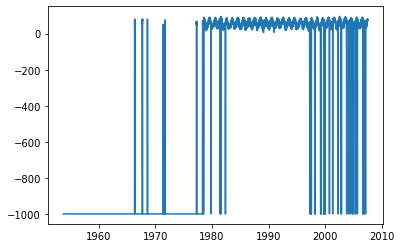

In [20]:
climate_data = data.data_df
plt.plot(climate_data['Date'], climate_data['tmax_0']);

We can mask out the no data values by either filtering the pandas dataframe or setting no data values to NaN values. This allows us to visualize the climite trends over the simulation period. 

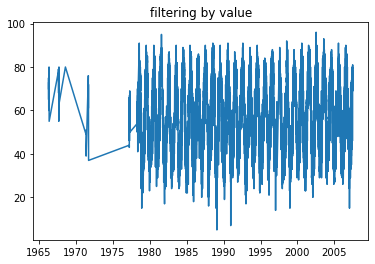

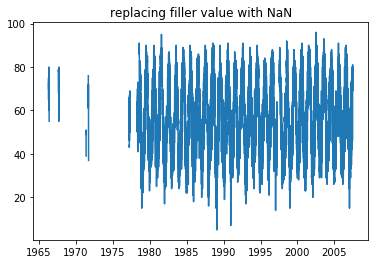

In [21]:
# filtering data 
df_to_plot = climate_data[climate_data['tmax_0']>-100]
plt.plot(df_to_plot['Date'], df_to_plot['tmax_0'])
plt.title('filtering by value')
plt.show()

# replacing -999 with np.nan
df_to_plot = climate_data.copy()
df_to_plot[df_to_plot.tmax_0 == -999] = np.nan
plt.plot(df_to_plot['Date'], df_to_plot['tmax_0'])
plt.title('replacing filler value with NaN');

### Adding a climate station to the `prms.data` object

The prms data object stores data as a pandas dataframe. Adding a station to the DataFrame is as simple as adding a new column and setting data to it.

In [22]:
## add a station
climate_data['precip_2'] = 10

In [23]:
climate_data.head(10)

,Year,Month,Day,Hour,Minute,Second,tmax_0,tmin_0,precip_0,runoff_0,Date,precip_2
0,1953,10,1,0,0,0,-999,-999,0.0,2.9,1953-10-01,10
1,1953,10,2,0,0,0,-999,-999,0.0,2.9,1953-10-02,10
2,1953,10,3,0,0,0,-999,-999,0.0,2.9,1953-10-03,10
3,1953,10,4,0,0,0,-999,-999,0.0,2.9,1953-10-04,10
4,1953,10,5,0,0,0,-999,-999,0.0,2.9,1953-10-05,10
5,1953,10,6,0,0,0,-999,-999,0.0,2.9,1953-10-06,10
6,1953,10,7,0,0,0,-999,-999,0.0,2.9,1953-10-07,10
7,1953,10,8,0,0,0,-999,-999,0.0,2.8,1953-10-08,10
8,1953,10,9,0,0,0,-999,-999,0.0,2.9,1953-10-09,10
9,1953,10,10,0,0,0,-999,-999,0.0,3.0,1953-10-10,10


### Removing station information from the dataframe

In [24]:
gs.prms.data.data_df.drop(columns=["precip_2"], inplace=True)
gs.prms.data.data_df

,Year,Month,Day,Hour,Minute,Second,tmax_0,tmin_0,precip_0,runoff_0,Date
0,1953,10,1,0,0,0,-999,-999,0.0,2.90,1953-10-01
1,1953,10,2,0,0,0,-999,-999,0.0,2.90,1953-10-02
2,1953,10,3,0,0,0,-999,-999,0.0,2.90,1953-10-03
3,1953,10,4,0,0,0,-999,-999,0.0,2.90,1953-10-04
4,1953,10,5,0,0,0,-999,-999,0.0,2.90,1953-10-05
...,...,...,...,...,...,...,...,...,...,...,...
19626,2007,6,26,0,0,0,78,32,0.0,2.25,2007-06-26
19627,2007,6,27,0,0,0,77,30,0.0,2.20,2007-06-27
19628,2007,6,28,0,0,0,72,31,0.0,2.17,2007-06-28
19629,2007,6,29,0,0,0,70,45,0.0,2.14,2007-06-29


### (2.d) Access MODFLOW data in pyGSFLOW 
All data related to MODFLOW can be accessed and assigned using `.mf` object. This object is pyGSFLOW `Modflow` instance that interacts with the python package Flopy; all operations in Flopy can be used here. MODFLOW is covered in notebook `2_Assemble_GSFLOW_model.ipynb`

In [25]:
# !jupyter nbconvert --to script pygsflow_intro.ipynb